<a href="https://colab.research.google.com/github/jdmarshall95/ML-DL-Labs/blob/main/LAB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импортируем бибилиотеки и приводим нашу таблицу к числовым значениям.

In [ ]:
import pandas as pd
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

from google.colab import drive
drive.mount ('/content/drive')

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bmw_pricing_challenge.csv', sep=',')
data.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   maker_key          4843 non-null   object
 1   model_key          4843 non-null   object
 2   mileage            4843 non-null   int64 
 3   engine_power       4843 non-null   int64 
 4   registration_date  4843 non-null   object
 5   fuel               4843 non-null   object
 6   paint_color        4843 non-null   object
 7   car_type           4843 non-null   object
 8   feature_1          4843 non-null   bool  
 9   feature_2          4843 non-null   bool  
 10  feature_3          4843 non-null   bool  
 11  feature_4          4843 non-null   bool  
 12  feature_5          4843 non-null   bool  
 13  feature_6          4843 non-null   bool  
 14  feature_7          4843 non-null   bool  
 15  feature_8          4843 non-null   bool  
 16  price           

К очистке данных применим тот же подход, что и в прошлый раз.

In [ ]:
data.drop(['maker_key','model_key'],axis=1,inplace=True)
data['RegistrationDate'] = [1 if(i>="1990-03-01" and i<"2000-01-01") else 2 if(i>="2000-01-01" and i<"2010-01-01")
                            else 3 for i in data['registration_date']]
data['SoldAt'] =[1 if(i=="2018-01-01") else 2 if(i=="2018-02-01") else 3 if(i=="2018-03-01")
                 else 4 if(i=="2018-04-01") else 5 if(i=="2018-05-01") else 6 if(i=="2018-06-01")
                 else 7 if(i=="2018-07-01") else 8 if(i=="2018-08-01")
                 else 9 if(i=="2018-09-01") else 0 for i in data['sold_at']]
data['fuel'] = data['fuel'].replace("diesel",1)
data['fuel'] = data['fuel'].replace("petrol",2)
data['fuel'] = data['fuel'].replace("hybrid_petrol",3)
data['fuel'] = data['fuel'].replace("electro",4)
data['paint_color'] = data['paint_color'].replace("black",1)
data['paint_color'] = data['paint_color'].replace("grey",2)
data['paint_color'] = data['paint_color'].replace("white",3)
data['paint_color'] = data['paint_color'].replace("red",4)
data['paint_color'] = data['paint_color'].replace("silver",5)
data['paint_color'] = data['paint_color'].replace("blue",6)
data['paint_color'] = data['paint_color'].replace("orange",7)
data['paint_color'] = data['paint_color'].replace("beige",8)
data['paint_color'] = data['paint_color'].replace("brown",9)
data['paint_color'] = data['paint_color'].replace("green",10)
data['car_type'].unique()
data['car_type'] = data['car_type'].replace("convertible",1)
data['car_type'] = data['car_type'].replace("coupe",2)
data['car_type'] = data['car_type'].replace("estate",3)
data['car_type'] = data['car_type'].replace("hatchback",4)
data['car_type'] = data['car_type'].replace("sedan",5)
data['car_type'] = data['car_type'].replace("subcompact",6)
data['car_type'] = data['car_type'].replace("suv",7)
data['car_type'] = data['car_type'].replace("van",8)
data['feature_1'] = data['feature_1'].replace(True,1)
data['feature_1'] = data['feature_1'].replace(False,0)
data['feature_2'] = data['feature_2'].replace(True,1)
data['feature_2'] = data['feature_2'].replace(False,0)
data['feature_3'] = data['feature_3'].replace(True,1)
data['feature_3'] = data['feature_3'].replace(False,0)
data['feature_4'] = data['feature_4'].replace(True,1)
data['feature_4'] = data['feature_4'].replace(False,0)
data['feature_5'] = data['feature_5'].replace(True,1)
data['feature_5'] = data['feature_5'].replace(False,0)
data['feature_6'] = data['feature_6'].replace(True,1)
data['feature_6'] = data['feature_6'].replace(False,0)
data['feature_7'] = data['feature_7'].replace(True,1)
data['feature_7'] = data['feature_7'].replace(False,0)
data['feature_8'] = data['feature_8'].replace(True,1)
data['feature_8'] = data['feature_8'].replace(False,0)
data.drop(['registration_date','sold_at'],axis=1,inplace=True)
data.head()

,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,RegistrationDate,SoldAt
0,140411,100,1,1,1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,11300,3,1
1,13929,317,2,2,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,69700,3,2
2,183297,120,1,3,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,10200,3,2
3,128035,135,1,4,1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,25100,3,2
4,97097,160,1,5,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,33400,3,4


Определим X (features)  и Y (labels). Y (labels)  - наш целевой параметр, X (features) - все остальное.


In [ ]:
labels = data[['feature_1']]
print("Check labels:", labels.head(3))
features = data.drop(['feature_1'], axis=1)
print("Check features:", features.head(3))

Check labels:    feature_1
0        1.0
1        1.0
2        0.0
Check features:    mileage  engine_power  fuel  ...  price  RegistrationDate  SoldAt
0   140411           100     1  ...  11300                 3       1
1    13929           317     2  ...  69700                 3       2
2   183297           120     1  ...  10200                 3       2

[3 rows x 15 columns]


Определим тестовые и тренировочные выборки.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(
    # метод для поиска решения. Для небольших датасетов лучше подходит liblinear, sag и saga -- для больших.
    # Варианты: newton-cg, lbfgs, liblinear, sag, saga
    solver='liblinear',
    # норма для регуляризации. Варианты: l2, l1.
    penalty='l1',
    # параметр регуляризации. Чем меньше, тем сильнее регуляризация. Положительный.
    C=1e4,
    # параметр для остановки поиска решения.(прекращается процесс обучения когда приближаемся к локальному минимому равному переменной tol)
    tol=1e-4,
    )

In [ ]:
model.fit(features, labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=10000.0, penalty='l1', solver='liblinear')

In [ ]:
predictions = model.predict(features)

In [ ]:
#Матрица ошибок
from sklearn import metrics
conf_mat = metrics.confusion_matrix(labels, predictions)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

,0.0,1.0
0.0,1422,759
1.0,601,2061


In [ ]:
pred_prob = model.predict_proba(features)

In [ ]:
predictions = pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(labels, predictions)
roc_auc = metrics.auc(fpr, tpr)

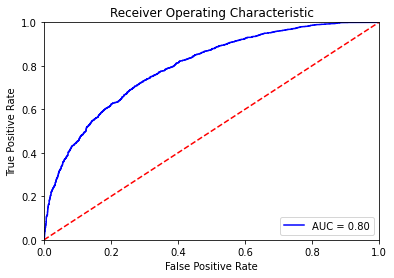

In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
model.coef_

array([[ 2.95946985e-06,  8.95923699e-03, -1.71271993e-01,
         4.13534497e-02, -4.98064059e-03,  9.92263024e-01,
         8.42237895e-01,  1.11328251e-01,  3.60644081e-01,
        -2.77144337e-02,  1.98131071e+00,  5.45723902e-02,
         6.90995808e-05, -1.30101492e+00,  8.55429881e-02]])

In [ ]:
col = [i for i in range(len(model.coef_[0]))]
listValues = model.coef_[0]
myDict = {col[i]:listValues[i] for i in range(0, len(col), 1)} 
for key in myDict:
    print(key, '->', myDict[key])

0 -> 2.9998333118928327e-06
1 -> 0.009128015937607422
2 -> -0.1545458771912919
3 -> 0.041932557222863744
4 -> -0.0023689807969446944
5 -> 1.0019759085167388
6 -> 0.8407025274117992
7 -> 0.09779929107092789
8 -> 0.3585662056895311
9 -> -0.030556579420639298
10 -> 2.057036988232341
11 -> 0.051482039597962555
12 -> 7.042357988801125e-05
13 -> -1.334671333638536
14 -> 0.08671268441680285


In [ ]:
# если значения признака меньше 0.01 удалим его (считаем их близкими к нулю)
key_new = list()
for key in myDict:
    if myDict[key] < 0.01:
        key_new.append(key)
print(key_new) # номера столбцов которые мы будем удалять для метода ближайших соседей

[0, 1, 2, 4, 9, 12, 13]


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bmw_pricing_challenge.csv', sep=',')
data['RegistrationDate'] = [1 if(i>="1990-03-01" and i<"2000-01-01") else 2 if(i>="2000-01-01" and i<"2010-01-01")
                            else 3 for i in data['registration_date']]
data['SoldAt'] =[1 if(i=="2018-01-01") else 2 if(i=="2018-02-01") else 3 if(i=="2018-03-01")
                 else 4 if(i=="2018-04-01") else 5 if(i=="2018-05-01") else 6 if(i=="2018-06-01")
                 else 7 if(i=="2018-07-01") else 8 if(i=="2018-08-01")
                 else 9 if(i=="2018-09-01") else 0 for i in data['sold_at']]
data['fuel'] = data['fuel'].replace("diesel",1)
data['fuel'] = data['fuel'].replace("petrol",2)
data['fuel'] = data['fuel'].replace("hybrid_petrol",3)
data['fuel'] = data['fuel'].replace("electro",4)
data['paint_color'] = data['paint_color'].replace("black",1)
data['paint_color'] = data['paint_color'].replace("grey",2)
data['paint_color'] = data['paint_color'].replace("white",3)
data['paint_color'] = data['paint_color'].replace("red",4)
data['paint_color'] = data['paint_color'].replace("silver",5)
data['paint_color'] = data['paint_color'].replace("blue",6)
data['paint_color'] = data['paint_color'].replace("orange",7)
data['paint_color'] = data['paint_color'].replace("beige",8)
data['paint_color'] = data['paint_color'].replace("brown",9)
data['paint_color'] = data['paint_color'].replace("green",10)
data['car_type'].unique()
data['car_type'] = data['car_type'].replace("convertible",1)
data['car_type'] = data['car_type'].replace("coupe",2)
data['car_type'] = data['car_type'].replace("estate",3)
data['car_type'] = data['car_type'].replace("hatchback",4)
data['car_type'] = data['car_type'].replace("sedan",5)
data['car_type'] = data['car_type'].replace("subcompact",6)
data['car_type'] = data['car_type'].replace("suv",7)
data['car_type'] = data['car_type'].replace("van",8)
data['feature_1'] = data['feature_1'].replace(True,1)
data['feature_1'] = data['feature_1'].replace(False,0)
data['feature_2'] = data['feature_2'].replace(True,1)
data['feature_2'] = data['feature_2'].replace(False,0)
data['feature_3'] = data['feature_3'].replace(True,1)
data['feature_3'] = data['feature_3'].replace(False,0)
data['feature_4'] = data['feature_4'].replace(True,1)
data['feature_4'] = data['feature_4'].replace(False,0)
data['feature_5'] = data['feature_5'].replace(True,1)
data['feature_5'] = data['feature_5'].replace(False,0)
data['feature_6'] = data['feature_6'].replace(True,1)
data['feature_6'] = data['feature_6'].replace(False,0)
data['feature_7'] = data['feature_7'].replace(True,1)
data['feature_7'] = data['feature_7'].replace(False,0)
data['feature_8'] = data['feature_8'].replace(True,1)
data['feature_8'] = data['feature_8'].replace(False,0)
data.drop(['registration_date','sold_at'],axis=1,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   maker_key         4843 non-null   object 
 1   model_key         4843 non-null   object 
 2   mileage           4843 non-null   int64  
 3   engine_power      4843 non-null   int64  
 4   fuel              4843 non-null   int64  
 5   paint_color       4843 non-null   int64  
 6   car_type          4843 non-null   int64  
 7   feature_1         4843 non-null   float64
 8   feature_2         4843 non-null   float64
 9   feature_3         4843 non-null   float64
 10  feature_4         4843 non-null   float64
 11  feature_5         4843 non-null   float64
 12  feature_6         4843 non-null   float64
 13  feature_7         4843 non-null   float64
 14  feature_8         4843 non-null   float64
 15  price             4843 non-null   int64  
 16  RegistrationDate  4843 non-null   int64  


In [ ]:
c = data.columns
for i in key_new:
  data.drop([c[i]], axis = 1, inplace = True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   engine_power      4843 non-null   int64  
 1   paint_color       4843 non-null   int64  
 2   car_type          4843 non-null   int64  
 3   feature_1         4843 non-null   float64
 4   feature_2         4843 non-null   float64
 5   feature_4         4843 non-null   float64
 6   feature_5         4843 non-null   float64
 7   feature_8         4843 non-null   float64
 8   price             4843 non-null   int64  
 9   RegistrationDate  4843 non-null   int64  
 10  SoldAt            4843 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 416.3 KB


In [ ]:
y = data['feature_1'] # целевая переменная
X = data.drop('feature_1', axis = 1) # признаки
X.shape

(4843, 10)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# импортируем класс классификатора по ближайшим соседям
from sklearn.neighbors import KNeighborsClassifier

# создадим наш классификатор
clf = KNeighborsClassifier(n_neighbors=3)
# обучим классификатор на тренировочной выборке
clf.fit(X_train, y_train)
# подсчитаем долю верных ответов алгоритма на тестовой выборке.
clf.score(X_test, y_test)

0.6143682906688687